In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

from PIL import Image

import tensorflow as tf

In [2]:
# %%bash
# source $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh
# echo $LD_LIBRARY_PATH

In [3]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
print(os.listdir("../voc_multi_semantic_seg_dataset"))

['class_names.txt', 'PNGImages', 'SegmentationClassPNG']


In [7]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 512 #Resize images (height  = X, width = Y)
SIZE_Y = 512

In [8]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("../voc_multi_semantic_seg_dataset/PNGImages"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [9]:
#Capture mask/label info as a list
train_masks = [] 

for directory_path in glob.glob("../voc_multi_semantic_seg_dataset/SegmentationClassPNG"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask[mask > 0] = 1
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [10]:
#Use customary x_train and y_train variables
X_train = train_images[0:21]
y_train = train_masks[0:21]
y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code 

In [11]:
#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [12]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [13]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)

1/1 [==============================] - 2s 2s/step


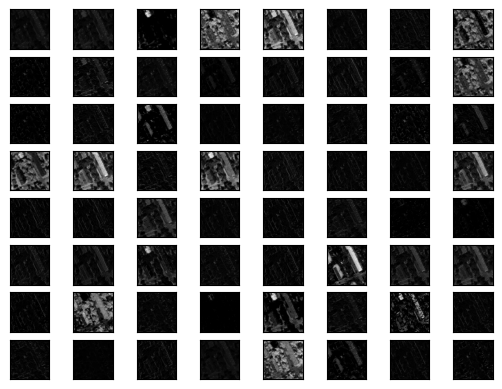

In [14]:
#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [15]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

In [16]:
#Reshape Y to match X
Y = y_train.reshape(-1)

In [17]:
#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

[0 1]
0    4344421
1    1160603
Name: Label, dtype: int64


In [18]:
##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
# dataset = dataset[dataset['Label'] != 0]

In [19]:
#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']

In [20]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50, random_state = 42, verbose=True, n_jobs=-1)

In [21]:
# Train the model on training data
model.fit(X_for_RF, Y_for_RF) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.2min finished


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42,
                       verbose=True)

In [22]:
#Save model for future use
filename = 'RF_model_bin.sav'
pickle.dump(model, open(filename, 'wb'))

In [23]:
#Load model.... 
loaded_model = pickle.load(open(filename, 'rb'))

In [24]:
#Test on a different image
#READ EXTERNAL IMAGE...
# test_img = cv2.imread('images/test_images/Sandstone_Versa0360.tif', cv2.IMREAD_COLOR)       
# test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
# test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
# test_img = np.expand_dims(test_img, axis=0)

In [27]:
predict_image = np.expand_dims(train_images[88,:,:,:], axis=0)
X_test_feature = new_model.predict(predict_image)

1/1 [==============================] - 0s 94ms/step


In [28]:
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

prediction = loaded_model.predict(X_test_feature)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.6s finished


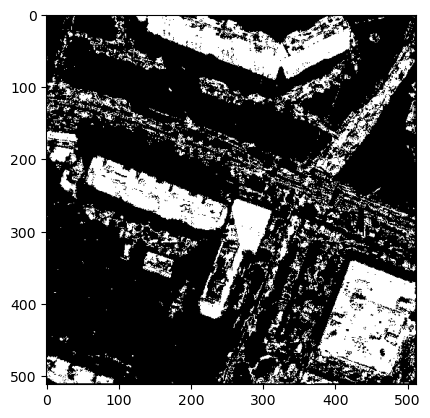

In [29]:
#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
# plt.imsave('images/test_images/360_segmented.jpg', prediction_image, cmap='gray')

In [32]:
print(features.shape)

(21, 512, 512, 64)


In [13]:
for directory_path in glob.glob("../voc_multi_semantic_seg_dataset/PNGImages"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        features=new_model.predict(img)
        features = features.reshape(features.shape[1:])
        features 
        # print(features.shape)
        for i in range(features.shape[2]):
            feature = features[:,:,i].reshape(features.shape[0:2])
            feature = Image.fromarray(feature).convert('RGB')
            # print(os.path.basename(img_path)[0:-4])
            feature.save(f"../VGG_features/{os.path.basename(img_path)[0:-4]}-{i}.png")

1/1 [==============================] - 0s 13ms/step
